# PyTorch

## Importar librerías

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [5]:
from get_images import get_images

In [6]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [7]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [8]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [9]:
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

## Mostrar imágenes 

In [10]:
x_test.shape

(10000, 784)

In [11]:
y_train.shape

(50000, 1)

In [12]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


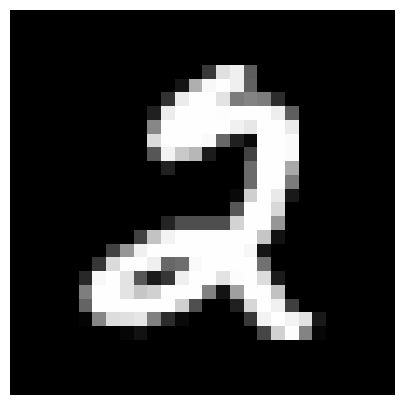

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [14]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [15]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cuda


## Compute accuracy 

In [17]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [18]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
    

## Modelo usando Sequential

In [19]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

Epoch: 0, costo: 1.937805414199829, accuracy: 0.69677734375
Epoch: 1, costo: 1.3454402685165405, accuracy: 0.783447265625
Epoch: 2, costo: 0.8758729696273804, accuracy: 0.84375
Epoch: 3, costo: 0.6599510908126831, accuracy: 0.858154296875
Epoch: 4, costo: 0.5481021404266357, accuracy: 0.879150390625
Epoch: 5, costo: 0.45031872391700745, accuracy: 0.890869140625
Epoch: 6, costo: 0.41673436760902405, accuracy: 0.89501953125
Epoch: 7, costo: 0.380154550075531, accuracy: 0.908203125
Epoch: 8, costo: 0.3563341796398163, accuracy: 0.89990234375
Epoch: 9, costo: 0.4021322429180145, accuracy: 0.9072265625
Epoch: 10, costo: 0.342348575592041, accuracy: 0.907958984375
Epoch: 11, costo: 0.3489837646484375, accuracy: 0.907470703125
Epoch: 12, costo: 0.3360469341278076, accuracy: 0.91015625
Epoch: 13, costo: 0.2878265976905823, accuracy: 0.92236328125
Epoch: 14, costo: 0.2979060113430023, accuracy: 0.9140625
Epoch: 15, costo: 0.3599095940589905, accuracy: 0.914306640625
Epoch: 16, costo: 0.30469742

In [20]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.962158203125